# 介紹

回想一下上一課中的範例，Keras 將在訓練模型的各個時期保留訓練和驗證損失的歷史記錄。在本課中，我們將學習如何解釋這些學習曲線以及如何使用它們來指導模型開發。特別是，我們將在學習曲線上檢查 *underfitting* 和 *overfitting* 的證據，並查看一些糾正它的策略。

# 解讀學習曲線 #

我們可能會認為訓練數據中的信息有兩種：*信號(signal)*和*雜訊(noise)*。信號是泛化(generalizes)的部分，可以幫助我們的模型根據新數據進行預測的部分。噪音是*僅訓練數據*真實的那部分；雜訊是來自現實世界中的數據的所有隨機波動，或者是實際上無法幫助模型做出預測的所有偶然的、非信息性的模式。噪音是該部分可能看起來有用但實際上不是。

我們通過選擇最小化訓練集損失的權重或參數來訓練模型。但是，我們可能知道，要準確評估模型的性能，我們需要在一組新數據（*驗證*數據）上對其進行評估。 （我們可以在 *Introduction to Machine Learning* 中查看我們關於 [模型驗證](https://www.kaggle.com/dansbecker/model-validation) 的課程進行回顧。）

當我們訓練一個模型時，我們一直在逐個地繪製訓練集上的損失。為此，我們還將添加**驗證數據圖**。這些圖我們稱之為**學習曲線**。為了有效地訓練深度學習模型，我們需要能夠解釋它們。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/tHiVFnM.png" width="500" alt="訓練和驗證損失圖。">
<figcaption style="textalign: center; font-style: italic"><center>驗證損失給出了對未見過數據的預期誤差的估計。
</center></figcaption>
</figure>

現在，無論是模型學習信號還是學習雜訊，訓練損失都會下降。但是只有當模型學習到信號時，驗證(預測X_test)損失才會下降。 （任何從訓練集中學到的雜訊都不會泛化到新數據上。）因此，當模型學習信號時，兩條曲線都會下降，但是當它學習雜訊時，會在曲線中創建一個 *gap*。差距的大小告訴你模型學到了多少噪音。

理想情況下，我們將創建學習所有信號而不學習雜訊的模型，但這不太可能。相反，我們進行交易: 我們可以讓模型以學習更多雜訊為代價學習更多信號。只要交易對我們有利，驗證損失就會繼續減少。然而，在某個點之後，**交易可能對我們不利**，成本超過收益，驗證損失開始上升。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/eUF6mfo.png" width="600" alt="兩張圖。在左邊，一條穿過幾個數據點的線與真正的拋物線擬合。在對，一條穿過每個數據點的曲線，真正擬合拋物線。">
<figcaption style="textalign: center; font-style: italic"><center>欠擬合和過擬合。
</center></figcaption>
</figure>

這種權衡表明在訓練模型時可能會出現兩個問題：**信號不足**或**雜訊過多**。 **欠擬合**訓練集是因為模型沒有學習到足夠的*信號*而導致損失沒有盡可能低。 **過度擬合**訓練集是因為模型學習了太多*雜訊*而導致損失沒有盡可能低。訓練深度學習模型的訣竅是在兩者之間找到最佳平衡。

我們將研究幾種從訓練數據中獲取更多信號同時減少雜訊量的方法。

# 容量(Capacity)

模型的**容量**是指它**能夠學習的模式的大小和復雜性**。對於神經網絡，這在很大程度上取決於**它有多少神經元**以及**它們如何連接在一起**。如果我們的網絡似乎欠擬合數據，我們應該嘗試**增加其容量**。

我們可以通過使其*更寬*（現有層更多單元）或使其*更深*（添加更多層）來增加網絡的容量。**更廣泛的網絡更容易學習更多的線性關係，而更深的網絡更喜歡更非線性的關係。**哪個更好取決於數據集。

```python
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])
# 學習更多的線性關係
wider = keras.Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])
# 學更多非線性的關係
deeper = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])
```

我們將探索網絡的容量如何影響其在練習中的性能。

# 提前停止

我們提到，當模型過於急切地學習雜訊時，驗證損失可能會在訓練期間開始增加。為了防止這種情況，只要驗**證損失似乎不再減少，我們就可以簡單地停止訓練**。以這種方式中斷訓練稱為**提前停止**。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/eP0gppr.png" width=500 alt="學習曲線圖，在最小驗證損失處提前停止，左側欠擬合，過擬合對。">
<figcaption style="textalign: center; font-style: italic"><center>我們將模型保持在驗證損失最小的地方。
</center></figcaption>
</figure>

一旦我們檢測到驗證損失再次開始上升，我們可以**將權重重置回最小值出現的位置**。這確保了模型不會繼續學習雜訊和過度擬合數據。

提前停止訓練也意味著我們在網絡完成學習信號之前過早停止訓練的危險較小。因此，除了防止過度擬合訓練時間過長之外，提前停止還可以防止 *underfitting* 訓練時間不夠長。只需將我們的訓練時期設置為較大的數字（超出我們的需要），然後提前停止即可處理其餘的問題。

## 添加提前停止##

在 Keras 中，我們透過引入"callback"提前停止訓練。 **callback** 只是我們希望在網絡訓練時經常運行的功能。提前停止回調將在每個 epoch 之後運行。 （Keras 有[各種有用的回調](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) 預定義，但你可以[定義自己的](https://www. tensorflow.org/api_docs/python/tf/keras/callbacks/LambdaCallback），也是。）

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, #N回合的的最小改進量
    patience=20, # 在前 20 個 epoch
    restore_best_weights=True, #保留找到的最佳模型
)

這些參數表示：“如果在前 20 個 epoch 中驗證損失沒有至少提高 0.001，那麼停止訓練並保留你找到的最佳模型。” 有時很難判斷驗證損失是由於過度擬合還是由於隨機批次(random batch)變異而上升。 這些參數讓我們圍繞何時停止設置一些餘量。(The parameters allow us to set some allowances around when to stop. 看不懂QQ)

正如我們將在範例中看到的，我們將將此回調與損失和優化器一起傳遞給 `fit` 方法。

# 範例 - 使用提前停止訓練模型 #

讓我們繼續從上一個教程中的範例開發模型。 我們將增加該網絡的容量，但還會添加一個提前停止回調以防止過度擬合。

這是再次準備數據。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from IPython.display import display

red_wine = pd.read_csv('/content/drive/MyDrive/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

Mounted at /content/drive


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


現在讓我們增加網絡的容量。 我們將選擇一個相當大的網絡，但是一旦驗證損失顯示出增加的跡象，就依靠回調來停止訓練。

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)

定義回調後，將其作為參數添加到 `fit` 中（可以有多個，所以放在一個列表中）。 使用提前停止時選擇大量的時期，比你需要的要多。

Epoch 1/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0780 - val_loss: 0.0950
Epoch 2/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0810 - val_loss: 0.0960
Epoch 3/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0792 - val_loss: 0.0949
Epoch 4/500
5/5 [==============================] - 0s 8ms/step - loss: 0.0779 - val_loss: 0.0968
Epoch 5/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0791 - val_loss: 0.0971
Epoch 6/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0755 - val_loss: 0.0946
Epoch 7/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0751 - val_loss: 0.0948
Epoch 8/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0761 - val_loss: 0.0944
Epoch 9/500
5/5 [==============================] - 0s 7ms/step - loss: 0.0755 - val_loss: 0.0945
Epoch 10/500
5/5 [==============================] - 0s 8ms/step - loss: 0.0752 - val_loss: 0.0951
Epoch 11/500
5/5 [==========

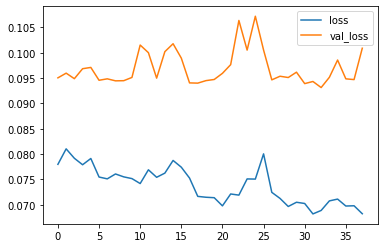

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # 把你的callback放在一個list中
    # verbose=0,  # 關閉訓練日誌
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

果然，Keras 在完整的 500 個 epoch 之前就停止了訓練！

# EXERCISE

現在 [**預測一首歌的受歡迎程度**](https://www.kaggle.com/kernels/fork/11906770) 使用 *Spotify* 數據集。